## Import librairies and data

In [5]:
import json
import numpy as np 
import os
import pandas as pd
from tqdm import tqdm, trange
import pickle
from flopth import flopth
import sys


from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


import seaborn as sns
from seaborn import color_palette
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import WeightedRandomSampler

sys.path.append(os.path.abspath('../models'))

from cnn import CNNClassifier
from mlp import MLP_Classifier


sys.path.append(os.path.abspath('../'))
from utils import *
from utils import ModelTrainer
from data_loader import DataSplitLoader

from hparams import hparams
hparams.parse_argument(args=["--batch_size", "128"])


-------------------------
Hyper Parameter Settings
-------------------------
batch_size: 128
num_epochs: 100
learning_rate: 0.1
stopping_rate: 1e-05
momentum: 0.6
factor: 0.2
patience: 30
condition: improvement
input_size: 1
hidden_size: 64
output_size: 64
pool_size: 3
threshold: 0.5
checkpoint_interval: 10
-------------------------


In [2]:
# Run if File pickle already exists in folder
with open('./DeepFake_Real_Sounds.pkl', 'rb') as file:
    data_final = pickle.load(file)


In [3]:
hparams.parse_argument(args=["--batch_size", "128", "--learning_rate","0.0007", "--momentum","0.9", "--num_epochs", "100","--threshold","0.5"])

train_loader,eval_loader,valid_loader = DataSplitLoader(data_final= data_final, hparams=hparams, embedding_type='vggish')

n_channels = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model_MLP = MLP_Classifier(n_channels,512,1).to(device)
name_model = 'model_MLP_vgg'
timer_starter, timer_ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
runs = 10
interval_length = 10
model_runs_dir = 'models_pann-wavegram_MLP'
models_infos = []


model_flops_MLP = MLP_Classifier(n_channels,n_channels,1)
input = torch.randn(hparams.batch_size,1,n_channels)  


flops_MLP, params = flopth(model_flops_MLP, inputs=(input,), show_detail=True)
print(f"Flops :{flops_MLP}")



for run in trange(runs):
    model_MLP = MLP_Classifier(n_channels,512,1).to(device)
    timings = []

    optimizer = optim.Adam(model_MLP.parameters(), lr = hparams.learning_rate)
    loss_function = nn.BCEWithLogitsLoss()
    scheduler=ReduceLROnPlateau(optimizer, mode='max', factor=hparams.factor, patience=hparams.patience, verbose=True)

    clf = ModelTrainer(model=model_MLP,optimizer=optimizer,loss_function=loss_function,hparams=hparams,scheduler=scheduler,verbose=True)

    # gpu_warm_up
    clf.warm_up_gpu(train_loader)
    # training model
    clf.train(train_loader=train_loader,valid_loader=valid_loader,timer_starter= timer_starter, timer_ender=timer_ender,timings = timings,name_model='model_MLP_vgg')
    # picking best model by best valid acc + save 
    model_MLP_best = clf.best_model()
    torch.save(model_MLP_best, f"./{model_runs_dir}/model_MLP_{run+1}.pth")
    # predictions on evaluation set
    true_labels, pred_labels = clf.predict(model=model_MLP_best,loader=eval_loader)
    accuracy = accuracy_score(true_labels, pred_labels)
    conf_matrix = confusion_matrix(true_labels, pred_labels)

    # save results for the best model
    os.makedirs(model_runs_dir, exist_ok=True)
    models_infos.append({'Model number': f'Model_MLP_pann_{run+1}',
                'Eval Accuracy': accuracy * 100 ,
                'Confusion Matrix': conf_matrix,
                'Epoch': clf.max_acc_epoch,
                'Valid Accuracy': clf.max_acc_value * 100 ,
                'Time/epoch' : np.mean(timings)/1000})
    models_infos = pd.DataFrame(models_infos)
    models_infos.to_pickle(f'./{model_runs_dir}/model_infos.pkl')

-------------------------
Hyper Parameter Settings
-------------------------
batch_size: 128
num_epochs: 100
learning_rate: 0.0007
stopping_rate: 1e-05
momentum: 0.9
factor: 0.2
patience: 30
condition: improvement
input_size: 1
hidden_size: 64
output_size: 64
pool_size: 3
threshold: 0.5
checkpoint_interval: 10
-------------------------


Warming up GPU: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Training of the model MLP_Classifier(
  (linear1): Linear(in_features=128, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=512, out_features=1024, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=512, out_features=1, bias=True)
) is starting ...


[Epoch 1/100] [Train Loss: 0.4268] [Train Acc: 0.8013] [Valid Loss: 0.3845] [Valid Acc: 0.7937]


[Epoch 2/100] [Train Loss: 0.4042] [Train Acc: 0.8107] [Valid Loss: 0.4282] [Valid Acc: 0.7603]


[Epoch 3/100] [Train Loss: 0.3970] [Train Acc: 0.8176] [Valid Loss: 0.4611] [Valid Acc: 0.7381]


[Epoch 4/100] [Train Loss: 0.3886] [Train Acc: 0.8218] [Valid Loss: 0.3564] [Valid Acc: 0.8050]


[Epoch 5/100] [Train Loss: 0.3696] [Train Acc: 0.8320] [Valid Loss: 0.3849] [Valid Acc: 0.7869]


[Epoch 6/100] [Train Loss: 0.3651] [Train Acc: 0.8334] [Valid Loss: 0.3663] [Valid Acc: 0.8119]


[Epoch 7/100] [Train Loss: 0.3606] [Train Acc: 0.8398] [Valid Loss: 0.3118] [Valid Acc: 0.8419]


[Epoch 8/100] [Train Loss: 0.3532] [Train Acc: 0.8416] [Valid Loss: 0.3222] [Valid Acc: 0.8303]


[Epoch 9/100] [Train Loss: 0.3456] [Train Acc: 0.8448] [Valid Loss: 0.3436] [Valid Acc: 0.8172]


[Epoch 10/100] [Train Loss: 0.3290] [Train Acc: 0.8571] [Valid Loss: 0.2775] [Valid Acc: 0.8638]
Model saved to ./model_checkpoints/model_MLP_vgg_epoch_10.pth


[Epoch 11/100] [Train Loss: 0.3261] [Train Acc: 0.8570] [Valid Loss: 0.3263] [Valid Acc: 0.8275]


[Epoch 12/100] [Train Loss: 0.3206] [Train Acc: 0.8590] [Valid Loss: 0.3496] [Valid Acc: 0.8209]


[Epoch 13/100] [Train Loss: 0.3103] [Train Acc: 0.8638] [Valid Loss: 0.3656] [Valid Acc: 0.8203]


[Epoch 14/100] [Train Loss: 0.3136] [Train Acc: 0.8626] [Valid Loss: 0.3488] [Valid Acc: 0.8156]


[Epoch 15/100] [Train Loss: 0.3022] [Train Acc: 0.8694] [Valid Loss: 0.3370] [Valid Acc: 0.8209]


[Epoch 16/100] [Train Loss: 0.2985] [Train Acc: 0.8706] [Valid Loss: 0.2980] [Valid Acc: 0.8534]


[Epoch 17/100] [Train Loss: 0.2969] [Train Acc: 0.8709] [Valid Loss: 0.2687] [Valid Acc: 0.8672]


[Epoch 18/100] [Train Loss: 0.2853] [Train Acc: 0.8740] [Valid Loss: 0.2988] [Valid Acc: 0.8475]


[Epoch 19/100] [Train Loss: 0.2879] [Train Acc: 0.8773] [Valid Loss: 0.2897] [Valid Acc: 0.8541]


[Epoch 20/100] [Train Loss: 0.2832] [Train Acc: 0.8766] [Valid Loss: 0.3665] [Valid Acc: 0.8134]
Model saved to ./model_checkpoints/model_MLP_vgg_epoch_20.pth


[Epoch 21/100] [Train Loss: 0.2803] [Train Acc: 0.8798] [Valid Loss: 0.2982] [Valid Acc: 0.8509]


[Epoch 22/100] [Train Loss: 0.2722] [Train Acc: 0.8858] [Valid Loss: 0.3266] [Valid Acc: 0.8397]


[Epoch 23/100] [Train Loss: 0.2743] [Train Acc: 0.8828] [Valid Loss: 0.3008] [Valid Acc: 0.8525]


[Epoch 24/100] [Train Loss: 0.2643] [Train Acc: 0.8880] [Valid Loss: 0.3029] [Valid Acc: 0.8500]


[Epoch 25/100] [Train Loss: 0.2686] [Train Acc: 0.8868] [Valid Loss: 0.2881] [Valid Acc: 0.8603]


[Epoch 26/100] [Train Loss: 0.2614] [Train Acc: 0.8894] [Valid Loss: 0.2989] [Valid Acc: 0.8500]


[Epoch 27/100] [Train Loss: 0.2595] [Train Acc: 0.8902] [Valid Loss: 0.2896] [Valid Acc: 0.8541]


[Epoch 28/100] [Train Loss: 0.2531] [Train Acc: 0.8946] [Valid Loss: 0.2952] [Valid Acc: 0.8547]


[Epoch 29/100] [Train Loss: 0.2552] [Train Acc: 0.8930] [Valid Loss: 0.2756] [Valid Acc: 0.8650]


[Epoch 30/100] [Train Loss: 0.2480] [Train Acc: 0.8987] [Valid Loss: 0.2809] [Valid Acc: 0.8666]
Model saved to ./model_checkpoints/model_MLP_vgg_epoch_30.pth


[Epoch 31/100] [Train Loss: 0.2493] [Train Acc: 0.8951] [Valid Loss: 0.3140] [Valid Acc: 0.8500]


[Epoch 32/100] [Train Loss: 0.2460] [Train Acc: 0.8951] [Valid Loss: 0.2603] [Valid Acc: 0.8725]


[Epoch 33/100] [Train Loss: 0.2464] [Train Acc: 0.8969] [Valid Loss: 0.2956] [Valid Acc: 0.8622]


[Epoch 34/100] [Train Loss: 0.2437] [Train Acc: 0.8977] [Valid Loss: 0.3102] [Valid Acc: 0.8600]


[Epoch 35/100] [Train Loss: 0.2402] [Train Acc: 0.9008] [Valid Loss: 0.2826] [Valid Acc: 0.8681]


[Epoch 36/100] [Train Loss: 0.2362] [Train Acc: 0.9038] [Valid Loss: 0.2644] [Valid Acc: 0.8769]


[Epoch 37/100] [Train Loss: 0.2339] [Train Acc: 0.9035] [Valid Loss: 0.2635] [Valid Acc: 0.8819]


[Epoch 38/100] [Train Loss: 0.2317] [Train Acc: 0.9054] [Valid Loss: 0.2685] [Valid Acc: 0.8709]


[Epoch 39/100] [Train Loss: 0.2341] [Train Acc: 0.9033] [Valid Loss: 0.2809] [Valid Acc: 0.8619]


[Epoch 40/100] [Train Loss: 0.2225] [Train Acc: 0.9091] [Valid Loss: 0.2770] [Valid Acc: 0.8688]
Model saved to ./model_checkpoints/model_MLP_vgg_epoch_40.pth


[Epoch 41/100] [Train Loss: 0.2242] [Train Acc: 0.9083] [Valid Loss: 0.2508] [Valid Acc: 0.8850]


[Epoch 42/100] [Train Loss: 0.2222] [Train Acc: 0.9080] [Valid Loss: 0.2663] [Valid Acc: 0.8716]


[Epoch 43/100] [Train Loss: 0.2233] [Train Acc: 0.9094] [Valid Loss: 0.2678] [Valid Acc: 0.8781]


[Epoch 44/100] [Train Loss: 0.2177] [Train Acc: 0.9108] [Valid Loss: 0.2782] [Valid Acc: 0.8784]


[Epoch 45/100] [Train Loss: 0.2164] [Train Acc: 0.9130] [Valid Loss: 0.2809] [Valid Acc: 0.8744]


[Epoch 46/100] [Train Loss: 0.2164] [Train Acc: 0.9122] [Valid Loss: 0.2689] [Valid Acc: 0.8738]


[Epoch 47/100] [Train Loss: 0.2195] [Train Acc: 0.9126] [Valid Loss: 0.2802] [Valid Acc: 0.8747]


[Epoch 48/100] [Train Loss: 0.2094] [Train Acc: 0.9156] [Valid Loss: 0.2525] [Valid Acc: 0.8853]


[Epoch 49/100] [Train Loss: 0.2107] [Train Acc: 0.9135] [Valid Loss: 0.3207] [Valid Acc: 0.8572]


[Epoch 50/100] [Train Loss: 0.2087] [Train Acc: 0.9144] [Valid Loss: 0.2710] [Valid Acc: 0.8781]
Model saved to ./model_checkpoints/model_MLP_vgg_epoch_50.pth


[Epoch 51/100] [Train Loss: 0.2049] [Train Acc: 0.9183] [Valid Loss: 0.2875] [Valid Acc: 0.8691]


[Epoch 52/100] [Train Loss: 0.2039] [Train Acc: 0.9178] [Valid Loss: 0.2577] [Valid Acc: 0.8878]


[Epoch 53/100] [Train Loss: 0.2008] [Train Acc: 0.9181] [Valid Loss: 0.2696] [Valid Acc: 0.8806]


[Epoch 54/100] [Train Loss: 0.1969] [Train Acc: 0.9197] [Valid Loss: 0.2648] [Valid Acc: 0.8862]


[Epoch 55/100] [Train Loss: 0.2022] [Train Acc: 0.9181] [Valid Loss: 0.2643] [Valid Acc: 0.8828]


[Epoch 56/100] [Train Loss: 0.1996] [Train Acc: 0.9207] [Valid Loss: 0.2702] [Valid Acc: 0.8841]


[Epoch 57/100] [Train Loss: 0.1962] [Train Acc: 0.9208] [Valid Loss: 0.2683] [Valid Acc: 0.8822]


[Epoch 58/100] [Train Loss: 0.1989] [Train Acc: 0.9211] [Valid Loss: 0.2677] [Valid Acc: 0.8831]


[Epoch 59/100] [Train Loss: 0.1896] [Train Acc: 0.9238] [Valid Loss: 0.2835] [Valid Acc: 0.8916]


[Epoch 60/100] [Train Loss: 0.1924] [Train Acc: 0.9257] [Valid Loss: 0.2671] [Valid Acc: 0.8878]
Model saved to ./model_checkpoints/model_MLP_vgg_epoch_60.pth


[Epoch 61/100] [Train Loss: 0.1914] [Train Acc: 0.9236] [Valid Loss: 0.2788] [Valid Acc: 0.8847]


[Epoch 62/100] [Train Loss: 0.1915] [Train Acc: 0.9227] [Valid Loss: 0.2801] [Valid Acc: 0.8819]


[Epoch 63/100] [Train Loss: 0.1839] [Train Acc: 0.9275] [Valid Loss: 0.2620] [Valid Acc: 0.8872]


[Epoch 64/100] [Train Loss: 0.1867] [Train Acc: 0.9259] [Valid Loss: 0.2616] [Valid Acc: 0.8931]


[Epoch 65/100] [Train Loss: 0.1836] [Train Acc: 0.9268] [Valid Loss: 0.2670] [Valid Acc: 0.8812]


[Epoch 66/100] [Train Loss: 0.1879] [Train Acc: 0.9257] [Valid Loss: 0.2608] [Valid Acc: 0.8909]


[Epoch 67/100] [Train Loss: 0.1860] [Train Acc: 0.9267] [Valid Loss: 0.2695] [Valid Acc: 0.8859]


[Epoch 68/100] [Train Loss: 0.1781] [Train Acc: 0.9290] [Valid Loss: 0.2784] [Valid Acc: 0.8888]


[Epoch 69/100] [Train Loss: 0.1754] [Train Acc: 0.9306] [Valid Loss: 0.2554] [Valid Acc: 0.8916]


[Epoch 70/100] [Train Loss: 0.1725] [Train Acc: 0.9320] [Valid Loss: 0.2817] [Valid Acc: 0.8844]
Model saved to ./model_checkpoints/model_MLP_vgg_epoch_70.pth


[Epoch 71/100] [Train Loss: 0.1773] [Train Acc: 0.9322] [Valid Loss: 0.2880] [Valid Acc: 0.8794]


[Epoch 72/100] [Train Loss: 0.1742] [Train Acc: 0.9308] [Valid Loss: 0.2640] [Valid Acc: 0.8919]


[Epoch 73/100] [Train Loss: 0.1769] [Train Acc: 0.9304] [Valid Loss: 0.2524] [Valid Acc: 0.8912]


[Epoch 74/100] [Train Loss: 0.1744] [Train Acc: 0.9316] [Valid Loss: 0.2742] [Valid Acc: 0.8878]


[Epoch 75/100] [Train Loss: 0.1756] [Train Acc: 0.9305] [Valid Loss: 0.2677] [Valid Acc: 0.8912]


[Epoch 76/100] [Train Loss: 0.1730] [Train Acc: 0.9328] [Valid Loss: 0.2461] [Valid Acc: 0.8975]


[Epoch 77/100] [Train Loss: 0.1669] [Train Acc: 0.9343] [Valid Loss: 0.2631] [Valid Acc: 0.8903]


[Epoch 78/100] [Train Loss: 0.1756] [Train Acc: 0.9299] [Valid Loss: 0.2562] [Valid Acc: 0.8956]


[Epoch 79/100] [Train Loss: 0.1685] [Train Acc: 0.9325] [Valid Loss: 0.2684] [Valid Acc: 0.8919]


[Epoch 80/100] [Train Loss: 0.1704] [Train Acc: 0.9322] [Valid Loss: 0.2751] [Valid Acc: 0.8838]
Model saved to ./model_checkpoints/model_MLP_vgg_epoch_80.pth


[Epoch 81/100] [Train Loss: 0.1653] [Train Acc: 0.9354] [Valid Loss: 0.2758] [Valid Acc: 0.8878]


[Epoch 82/100] [Train Loss: 0.1634] [Train Acc: 0.9366] [Valid Loss: 0.2469] [Valid Acc: 0.8991]


[Epoch 83/100] [Train Loss: 0.1581] [Train Acc: 0.9381] [Valid Loss: 0.2540] [Valid Acc: 0.9006]


[Epoch 84/100] [Train Loss: 0.1616] [Train Acc: 0.9354] [Valid Loss: 0.3156] [Valid Acc: 0.8719]


[Epoch 85/100] [Train Loss: 0.1621] [Train Acc: 0.9387] [Valid Loss: 0.2483] [Valid Acc: 0.9031]


[Epoch 86/100] [Train Loss: 0.1594] [Train Acc: 0.9377] [Valid Loss: 0.2587] [Valid Acc: 0.8906]


[Epoch 87/100] [Train Loss: 0.1616] [Train Acc: 0.9365] [Valid Loss: 0.2797] [Valid Acc: 0.8903]


[Epoch 88/100] [Train Loss: 0.1561] [Train Acc: 0.9371] [Valid Loss: 0.2633] [Valid Acc: 0.8956]


[Epoch 89/100] [Train Loss: 0.1563] [Train Acc: 0.9386] [Valid Loss: 0.2519] [Valid Acc: 0.8994]


[Epoch 90/100] [Train Loss: 0.1541] [Train Acc: 0.9403] [Valid Loss: 0.2611] [Valid Acc: 0.8962]
Model saved to ./model_checkpoints/model_MLP_vgg_epoch_90.pth


[Epoch 91/100] [Train Loss: 0.1568] [Train Acc: 0.9396] [Valid Loss: 0.2533] [Valid Acc: 0.8950]


[Epoch 92/100] [Train Loss: 0.1521] [Train Acc: 0.9391] [Valid Loss: 0.2566] [Valid Acc: 0.9034]


[Epoch 93/100] [Train Loss: 0.1458] [Train Acc: 0.9444] [Valid Loss: 0.2602] [Valid Acc: 0.8941]


[Epoch 94/100] [Train Loss: 0.1509] [Train Acc: 0.9403] [Valid Loss: 0.2633] [Valid Acc: 0.8950]


  0%|          | 0/10 [01:46<?, ?it/s]


KeyboardInterrupt: 

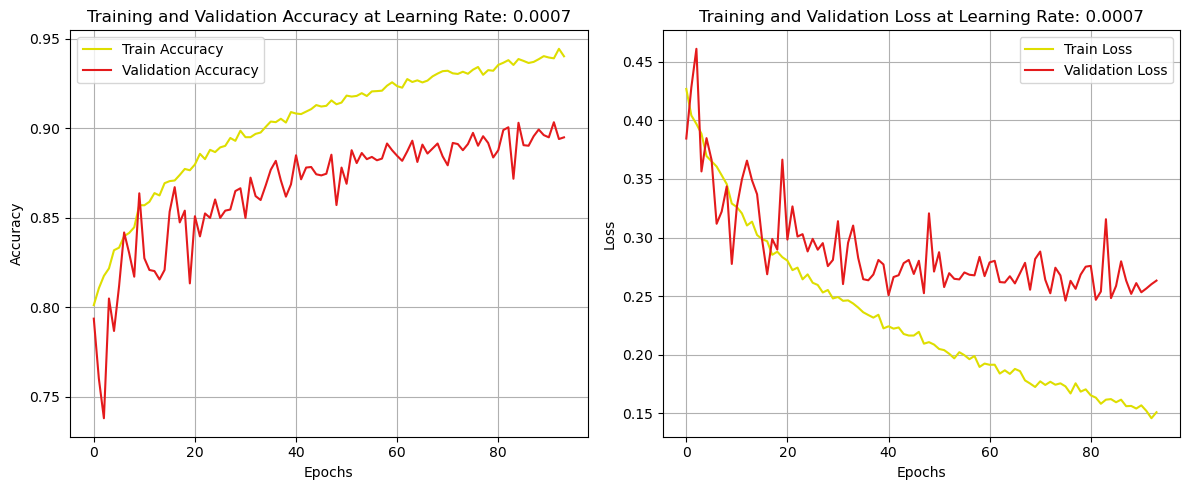

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  
color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# color_palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

axs[0].plot(np.array(clf.train_acc_plot), label='Train Accuracy', color=color_palette[8])
axs[0].plot(np.array(clf.valid_acc_plot), label='Validation Accuracy', color=color_palette[7])
axs[0].set_title(f'Training and Validation Accuracy at Learning Rate: {hparams.learning_rate}')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.array(clf.train_loss_plot), label='Train Loss', color=color_palette[8])
axs[1].plot(np.array(clf.valid_loss_plot), label='Validation Loss', color=color_palette[7])
axs[1].set_title(f'Training and Validation Loss at Learning Rate: {hparams.learning_rate}')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## Prediction on Evaluation set + Confusion Matrix computation

In [38]:
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Confusion Matrix:\n', conf_matrix)

NameError: name 'accuracy' is not defined